In [12]:
import pandas as pd
import numpy as np
import io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# === BƯỚC 1: Đọc dữ liệu ===
df = pd.read_csv("london_weather.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.head()

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0 1979-01-01          2.0       7.0              52.0       2.3       -4.1   
1 1979-01-02          6.0       1.7              27.0       1.6       -2.6   
2 1979-01-03          5.0       0.0              13.0       1.3       -2.8   
3 1979-01-04          8.0       0.0              13.0      -0.3       -2.6   
4 1979-01-05          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         9.0  
1      -7.5            0.0  102530.0         8.0  
2      -7.2            0.0  102050.0         4.0  
3      -6.5            0.0  100840.0         2.0  
4      -1.4            0.0  102250.0         1.0

In [4]:
# Kiểm tra số lượng giá trị bị thiếu trong mỗi cột
print("Số lượng giá trị thiếu trước khi xử lý:")
print(df.isnull().sum())

# Lặp qua từng cột và điền giá trị thiếu bằng giá trị trung bình của cột đó
for col in df.columns:
    if df[col].isnull().any():
        # Chỉ điền cho các cột số
        if pd.api.types.is_numeric_dtype(df[col]):
            mean_value = df[col].mean()
            df[col].fillna(mean_value, inplace=True)

print("\nSố lượng giá trị thiếu sau khi xử lý:")
print(df.isnull().sum())

Số lượng giá trị thiếu trước khi xử lý:
date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

Số lượng giá trị thiếu sau khi xử lý:
date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64


C:\Users\lenovo\AppData\Local\Temp\ipykernel_13404\2627111882.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_value, inplace=True)


In [6]:
# Chọn biến mục tiêu (y) và các biến đặc trưng (X)
# Bỏ cột 'date' vì nó không phải là một đặc trưng số trực tiếp
features = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']
target = 'mean_temp'

X = df[features]
y = df[target]

# Phân chia dữ liệu thành tập huấn luyện (80%) và tập kiểm tra (20%)
# random_state được dùng để đảm bảo kết quả có thể tái tạo được
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nKích thước tập huấn luyện (X_train): {X_train.shape}")
print(f"Kích thước tập kiểm tra (X_test): {X_test.shape}")


Kích thước tập huấn luyện (X_train): (12272, 8)
Kích thước tập kiểm tra (X_test): (3069, 8)


In [7]:
# Khởi tạo mô hình Bayesian Ridge
bayesian_model = BayesianRidge()

# Huấn luyện mô hình với dữ liệu training
print("\nBắt đầu huấn luyện mô hình...")
bayesian_model.fit(X_train, y_train)
print("Huấn luyện hoàn tất.")


Bắt đầu huấn luyện mô hình...
Huấn luyện hoàn tất.


In [14]:
# Dự đoán trên tập dữ liệu kiểm tra
y_pred = bayesian_model.predict(X_test)

# Đánh giá mô hình
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n--- Kết quả đánh giá mô hình ---")
print(f"MAE: {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} (độ C)")
print(f"R-squared (R²): {r2:.2f}")


--- Kết quả đánh giá mô hình ---
MAE: 0.69
Mean Squared Error (MSE): 0.84
Root Mean Squared Error (RMSE): 0.92 (độ C)
R-squared (R²): 0.97


In [10]:
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = safe_mape(y_test, y_pred)
print("MAPE:", round(mape, 2), "%")

MAPE: 10.78 %


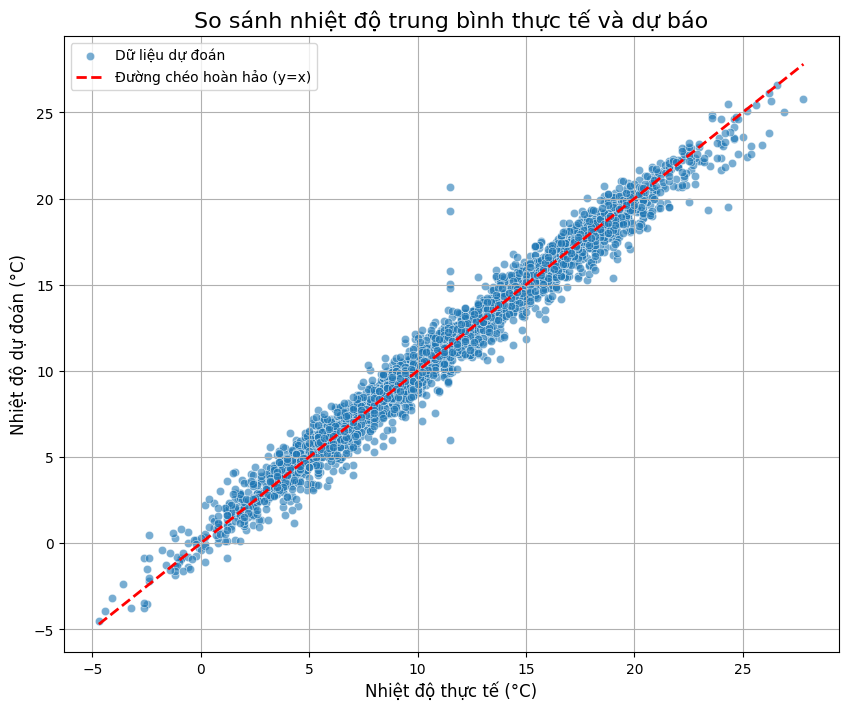

In [11]:
# Tạo DataFrame để dễ dàng trực quan hóa
results_df = pd.DataFrame({'Thực tế': y_test, 'Dự báo': y_pred})

# Vẽ biểu đồ
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Thực tế', y='Dự báo', data=results_df, alpha=0.6, label='Dữ liệu dự đoán')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Đường chéo hoàn hảo (y=x)')

plt.title('So sánh nhiệt độ trung bình thực tế và dự báo', fontsize=16)
plt.xlabel('Nhiệt độ thực tế (°C)', fontsize=12)
plt.ylabel('Nhiệt độ dự đoán (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()